# Amazon Employee Access Challenge
## Context
When an employee at any company starts work, they first need to obtain the computer access necessary to fulfill their role. This access may allow an employee to read/manipulate resources through various applications or web portals. It is assumed that employees fulfilling the functions of a given role will access the same or similar resources. It is often the case that employees figure out the access they need as they encounter roadblocks during their daily work (e.g. not able to log into a reporting portal). A knowledgeable supervisor then takes time to manually grant the needed access in order to overcome access obstacles. As employees move throughout a company, this access discovery/recovery cycle wastes a nontrivial amount of time and money.

There is a considerable amount of data regarding an employee’s role within an organization and the resources to which they have access. Given the data related to current employees and their provisioned access, models can be built that automatically determine access privileges as employees enter and leave roles within a company. These auto-access models seek to minimize the human involvement required to grant or revoke employee access.

Part of the competition "Amazon.com - Employee Access Challenge" (https://www.kaggle.com/c/amazon-employee-access-challenge), the data consists of real historical data collected from 2010 & 2011. Employees are manually allowed or denied access to resources over time. Your task is to create an algorithm capable of learning from this historical data to predict approval/denial for an unseen set of employees.

## Content
The data comes from Amazon Inc. collected from 2010-2011 (published on Kaggle platform). The training set consists of 32769 samples and the testing one of 58922 samples. The training set has one label attribute named “ACTION”, whose value “1” indicates an application is approved whereas “0” indicates rejection. As predictors of this state, there are eight features, indicating characteristics of the required resource anf the role and work group of the employee at Amazon requesting access.

train.csv - The training set. Each row has the ACTION (ground truth), RESOURCE, and information about the employee's role at the time of approval

test.csv - The test set for which predictions should be made. Each row asks whether an employee having the listed characteristics should have access to the listed resource.

| Column Name |	Description |
| --- | --- |
| ACTION |	ACTION is 1 if the resource was approved, 0 if the resource was not |
| RESOURCE | An ID for each resource |
| MGR_ID | The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time |
| ROLEROLLUP1 |	Company role grouping category id 1 (e.g. US Engineering) |
| ROLEROLLUP2 |	Company role grouping category id 2 (e.g. US Retail) |
| ROLE_DEPTNAME | Company role department description (e.g. Retail) |
| ROLE_TITLE | Company role business title description (e.g. Senior Engineering Retail Manager) |
| ROLEFAMILYDESC | Company role family extended description (e.g. Retail Manager, Software Engineering) |
| ROLE_FAMILY |	Company role family description (e.g. Retail Manager) |
| ROLE_CODE | Company role code; this code is unique to each role (e.g. Manager) |

Models are judged on area under the ROC curve (https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

## Acknowledgements
The data has been donated by Amazon and the original competition has been hosted in collaboration with the IEEE International Workshop on Machine Learning for Signal Processing (MLSP 2013)

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
sns.set()

from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier,RandomForestClassifier,StackingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

C:\Users\arc_e\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Overview

In [2]:
employee = pd.read_csv("train.csv")
df = employee.copy()
df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [3]:
df.shape

(32769, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


The dataset consists of 32769 rows and 10 columns. No missing values. All columns are integers. `ACTION` column is the target.

In [5]:
df.nunique()  # check number of unique values

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

Most of the columns have 100+ unique values. `ACTION` has only two values.

In [6]:
df.describe()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,0.942110,42923.916171,25988.957979,116952.627788,118301.823156,118912.779914,125916.152644,170178.369648,183703.408893,119789.430132
std,0.233539,34173.892702,35928.031650,10875.563591,4551.588572,18961.322917,31036.465825,69509.462130,100488.407413,5784.275516
min,0.000000,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.000000,117880.000000
25%,1.000000,20299.000000,4566.000000,117961.000000,118102.000000,118395.000000,118274.000000,117906.000000,118363.000000,118232.000000
50%,1.000000,35376.000000,13545.000000,117961.000000,118300.000000,118921.000000,118568.000000,128696.000000,119006.000000,118570.000000
75%,1.000000,74189.000000,42034.000000,117961.000000,118386.000000,120535.000000,120006.000000,235280.000000,290919.000000,119348.000000
max,1.000000,312153.000000,311696.000000,311178.000000,286791.000000,286792.000000,311867.000000,311867.000000,308574.000000,270691.000000


All columns except `ACTION` have similar scales.

# EDA

In [7]:
df.columns

Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE'],
      dtype='object')

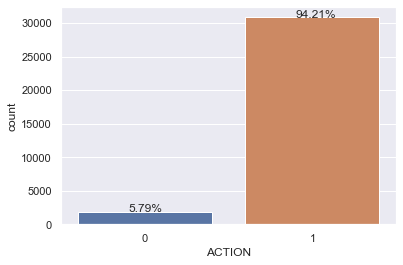

In [8]:
ax = sns.countplot(x ='ACTION', data = df);
for p in ax.patches:
    percent = np.round(p.get_height()/df.shape[0] * 100, 2)
    x = p.get_x() + p.get_width()/2 - 0.1
    y = p.get_y() + p.get_height() + 0.1
    ax.annotate(str(percent) + "%", (x,y));

Class labels are imbalanced. 94% of the total are granted access to the resource.

In [9]:
def histogram_boxplot(col):
    """
    Show histogram and boxplot of column "col".
    """
    plt.figure(figsize = (7,10))
    gs = GridSpec(2,1, hspace = 0.2)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    sns.histplot(ax = ax0, data = df[col], kde = True);
    sns.boxplot(ax = ax1,x = col, data = df, color = "yellow", showmeans = True);

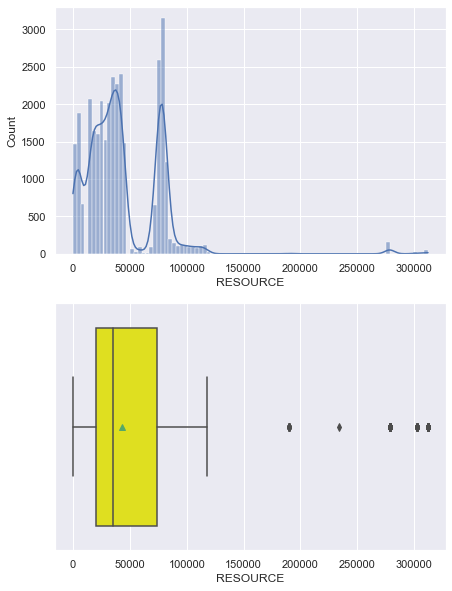

In [10]:
histogram_boxplot('RESOURCE')

`RESOURCE` shows a two-peak pattern with a few outliers on the right. But we couldn't do outlier treatment because this column represents the ID for resource.

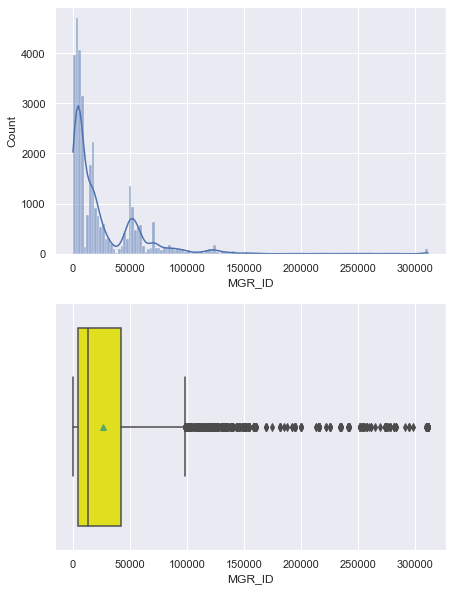

In [11]:
histogram_boxplot('MGR_ID')

More than 75% of `MGR_ID` are less than 50000. The long tail on the right again indicates outliers but we couldn't do outlier treatment because it represents the EMPLOYEE ID of the manager of the current employee.

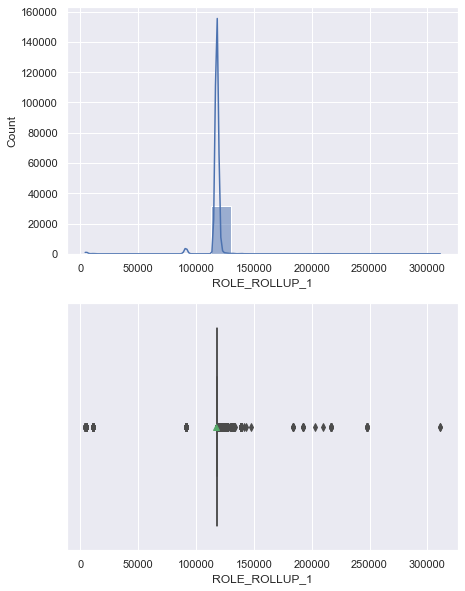

In [12]:
histogram_boxplot('ROLE_ROLLUP_1')

Most data concentrate on 117961, with a few outliers on both sides. We couldn't do outlier treatment because this column represents Company role grouping category id 1.

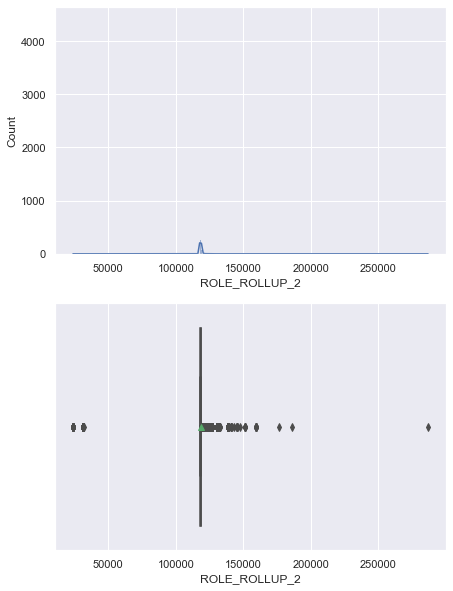

In [13]:
histogram_boxplot('ROLE_ROLLUP_2')

Most data concentrate on 118300, with a few outliers on both sides. We couldn't do outlier treatment because this column represents Company role grouping category id 2.

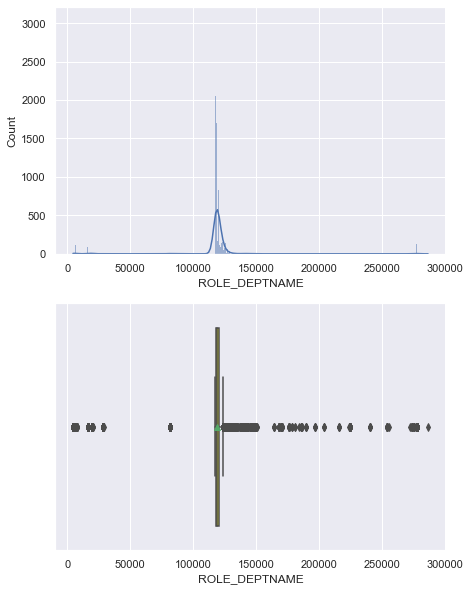

In [14]:
histogram_boxplot('ROLE_DEPTNAME')

Most data concentrate on 118921, with a few outliers on both sides. We couldn't do outlier treatment because the values in this column correspond to Company role department description.

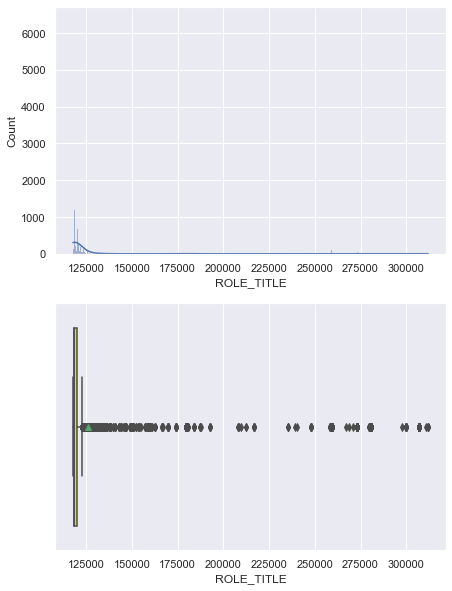

In [15]:
histogram_boxplot('ROLE_TITLE')

Most data concentrate on 118568, with lots of outliers on the right. We couldn't do outlier treatment because the values in this column correspond to Company role business title description.

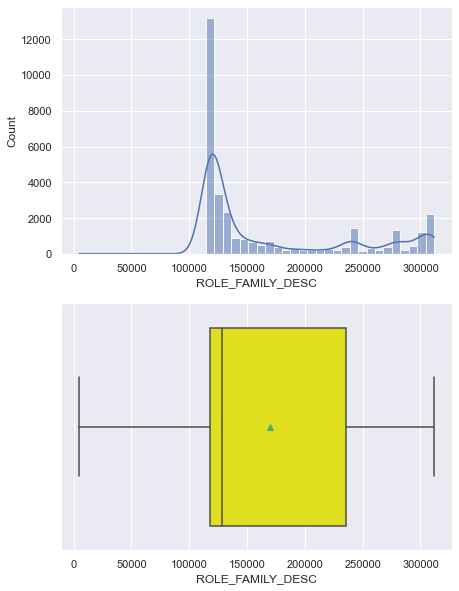

In [16]:
histogram_boxplot('ROLE_FAMILY_DESC')

Right-skewed distribution.

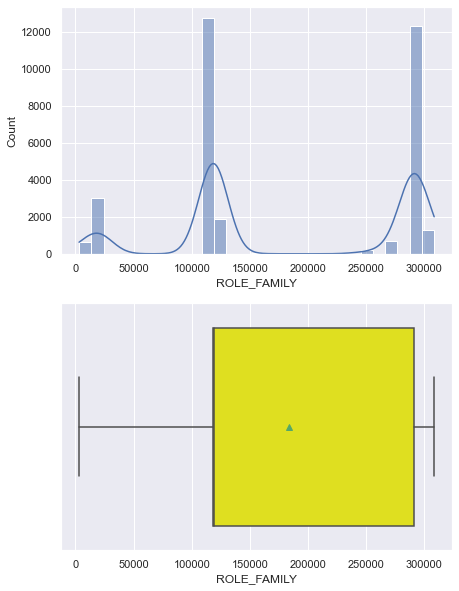

In [17]:
histogram_boxplot('ROLE_FAMILY')

Data are grouped in three groups.

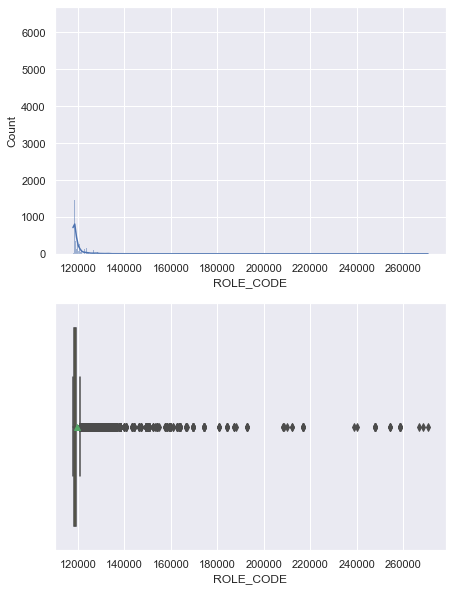

In [18]:
histogram_boxplot('ROLE_CODE')

Data concentrate on 11857, with lots of outliers on the right. We couldn't do outlier treatment because the values in this column correspond to Company role code.

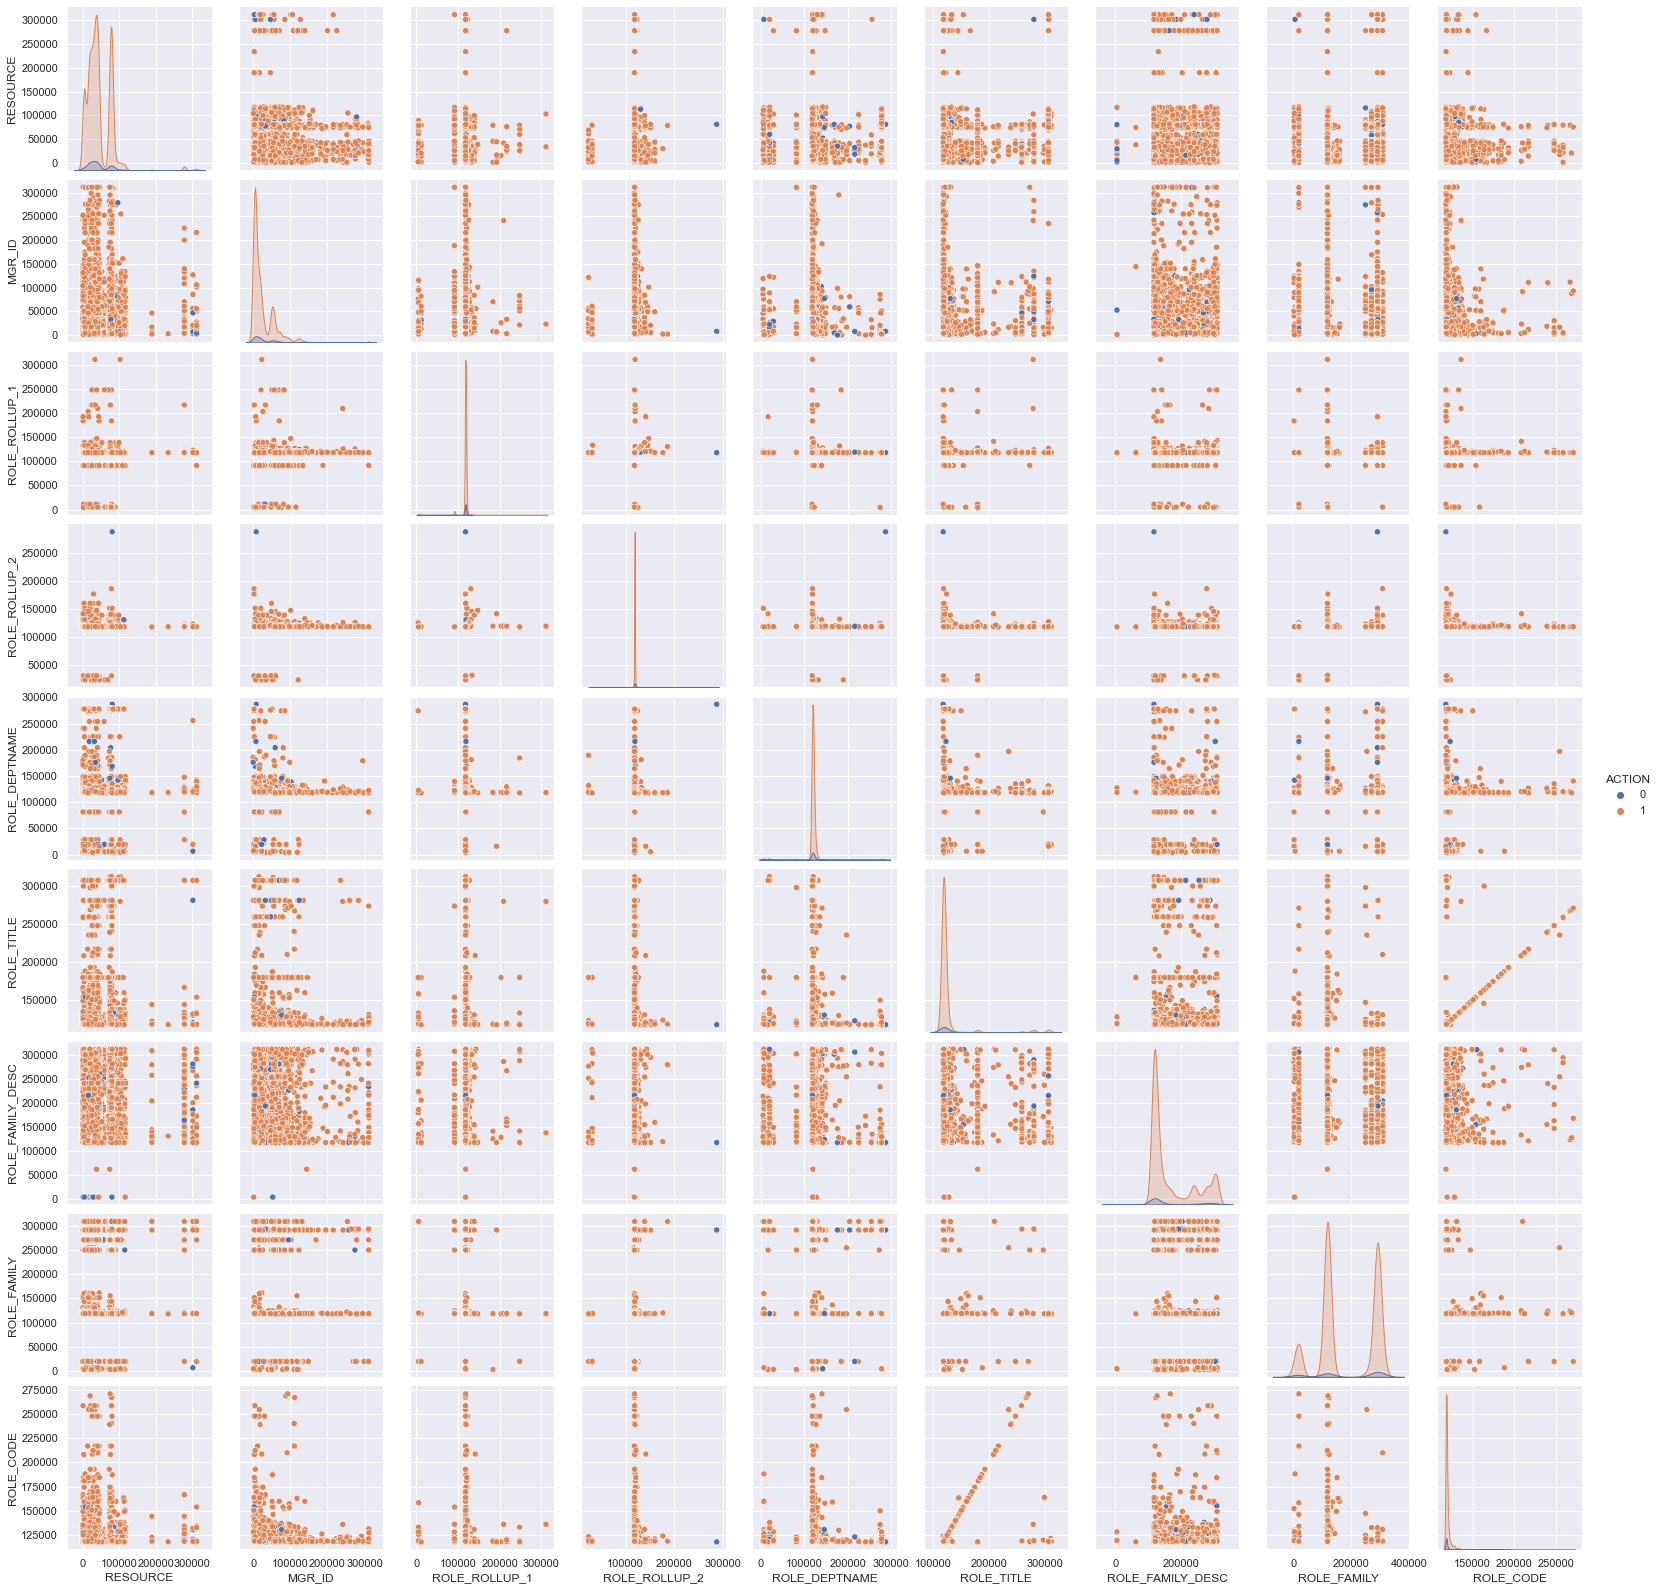

In [19]:
sns.pairplot(data = df,diag_kind = "kde", hue = "ACTION");

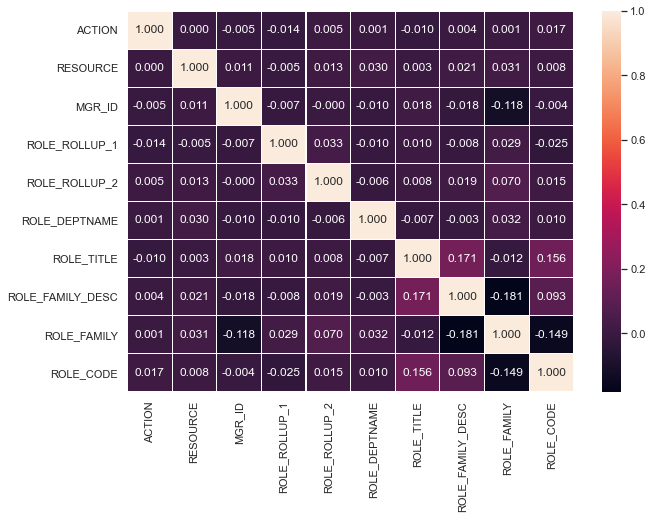

In [20]:
plt.figure(figsize = (10,7));
sns.heatmap(data = df.corr(), annot = True, fmt = ".3f", linewidth = 0.1);

No significant correlation exist among columns.

# Iteration 1 - Cross Validation of Ensemble Models

In [21]:
seed = 13   # seed for random state
X = df.drop(columns = ["ACTION"])
y = df["ACTION"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed, stratify = y, shuffle = True)
X_train.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
17164,31983,6530,118074,23779,117920,119323,129197,19793,119325
26008,80313,7084,117961,118386,121961,118321,117906,290919,118322
24643,80872,7253,117961,118225,118403,117905,117906,290919,117908
31181,75329,3270,117961,118225,122870,118563,123784,270488,118565
13143,79315,17733,117961,118300,119984,120647,311441,118398,120649


In [22]:
X_test.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
13361,81502,278563,118602,118603,117941,118568,118568,19721,118570
29172,78311,71097,117932,117933,117878,117899,130906,19721,117900
28353,28354,5244,117961,118343,119598,118321,240983,290919,118322
20229,4675,5537,117961,118413,120370,117905,117906,290919,117908
27164,34924,74831,117961,118327,118391,117905,117906,290919,117908


In [23]:
X_final_test = pd.read_csv("test.csv")   # test set for submission
X_final_test.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [24]:
final_test_id = X_final_test.id   # id in the final submission
X_final_test = X_final_test.drop(columns = ["id"])
X_final_test.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [25]:
print("X_train:", X_train.shape)
print("y_train", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("X_final_test:", X_final_test.shape)

X_train: (22938, 9)
y_train (22938,)
X_test: (9831, 9)
y_test: (9831,)
X_final_test: (58921, 9)


In [26]:
scorer = "roc_auc"
kfold = StratifiedKFold(shuffle=True, random_state=seed)

# models
adc = AdaBoostClassifier(random_state = seed)
gbc = GradientBoostingClassifier(random_state = seed)
bgc = BaggingClassifier(n_jobs = -1, random_state = seed)
rf = RandomForestClassifier(n_jobs = -1, random_state = seed)
xgb = XGBClassifier(objective='binary:logistic', random_state = seed, n_jobs = -1)
stack = StackingClassifier(estimators = [("adc",adc), ("gbc",gbc), ("bgc",bgc), ("rf",rf),("xgb", xgb)], 
                           cv=kfold, n_jobs=-1, passthrough=True)

model_list = [("AdaBoost", adc), ("GradientBoost", gbc), ("Bagging", bgc), ("RandomForest", rf),
              ("XGB", xgb),("Stacking", stack)]
results = []   # CV auc scores

for _, model in model_list:
    res = cross_val_score(estimator = model,X = X_train, y = y_train, scoring = scorer, cv = kfold, n_jobs = -1)
    results.append(res)

AdaBoost : 0.6967921482261178
GradientBoost : 0.744927016470743
Bagging : 0.7789707815766267
RandomForest : 0.823251826688949
XGB : 0.8182184512077783
Stacking : 0.5266911174892694


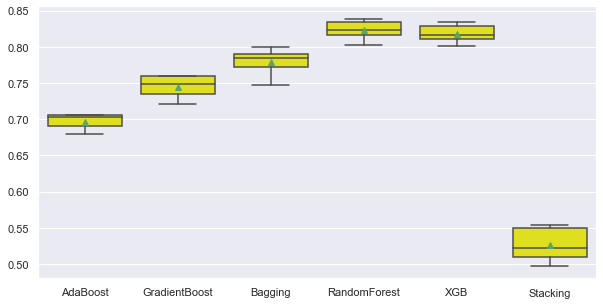

In [27]:
for i, res in enumerate(results):
    print(model_list[i][0], ":", res.mean())
    
plt.figure(figsize = (10,5))    
sns.boxplot(data = results, showmeans = True, color = "yellow");
plt.xticks(np.arange(len(model_list)), [name for name, _ in model_list]);

CV AUC score: RandomForest > XGBoost > Bagging > GradientBosst > AdaBoost > Stacking.

In [28]:
auc_compare = pd.DataFrame(columns = ["Model", "Train AUC", "Test AUC"]).set_index("Model")   # a dataframe to compare model metrics

In [29]:
def auc_score_plot(model_name, model, X_train, y_train, X_test, y_test):
    """
    Compute the auc for train and test set and plot the roc curve.
    """
    model = model.fit(X_train, y_train)
    y_train_prob = model.predict_proba(X_train)[:,1]
    y_test_prob = model.predict_proba(X_test)[:,1]
    metrics = []
    plt.figure(figsize = (10,5))
    
    plt.subplot(1,2,1)
    fpr, tpr, thresholds = roc_curve(y_train, y_train_prob)
    plt.plot([0,1], [0,1], "b-", label = "baseline");
    plt.plot(fpr,tpr, "r--", label = model_name);
    plt.xlim(-0.01,1.01);
    plt.ylim(-0.01,1.01);
    plt.xlabel("fpr");
    plt.ylabel("tpr");
    auc_score = auc(fpr,tpr);
    plt.title("train auc:" + str(auc_score));
    plt.legend(loc = "lower right")
    metrics.append(auc_score)
    
    plt.subplot(1,2,2)
    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
    plt.plot([0,1], [0,1], "b-", label = "baseline");
    plt.plot(fpr,tpr, "r--", label = model_name);
    plt.xlim(-0.01,1.01);
    plt.ylim(-0.01,1.01);
    plt.xlabel("fpr");
    plt.ylabel("tpr");
    auc_score = auc(fpr,tpr);
    plt.title("test auc:" + str(auc_score));
    plt.legend(loc = "lower right")
    metrics.append(auc_score)
    
    return metrics

C:\Users\arc_e\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\arc_e\anaconda3\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[13:31:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


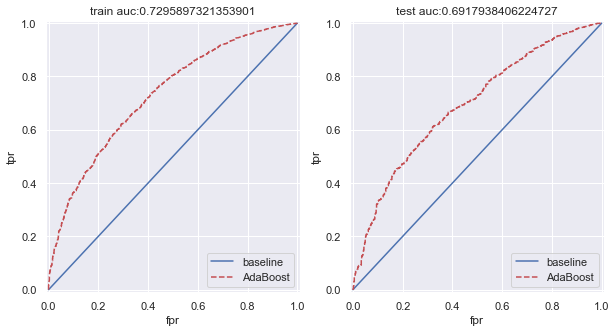

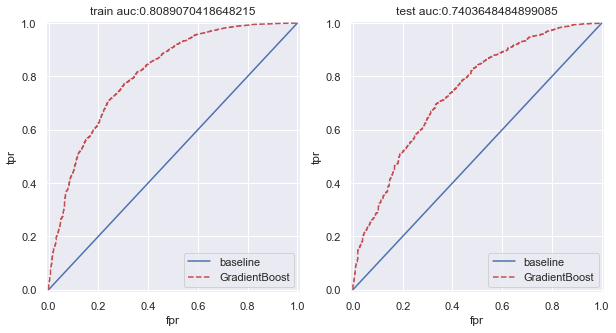

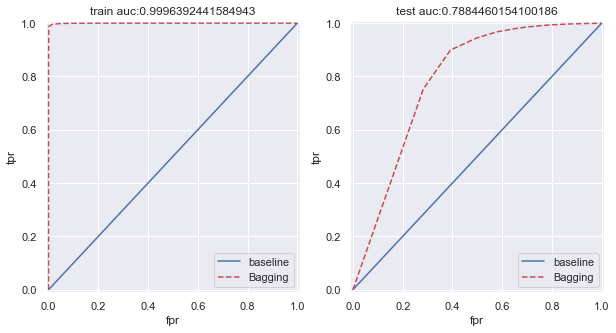

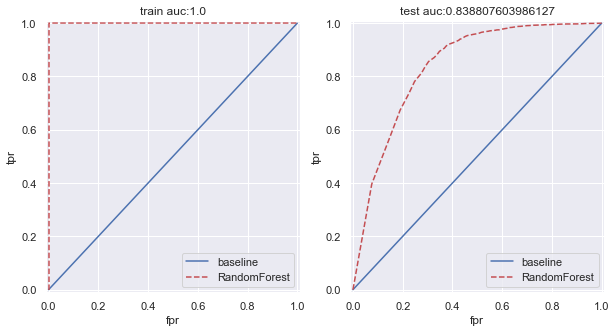

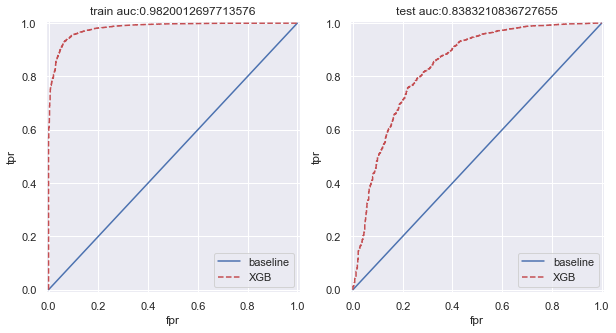

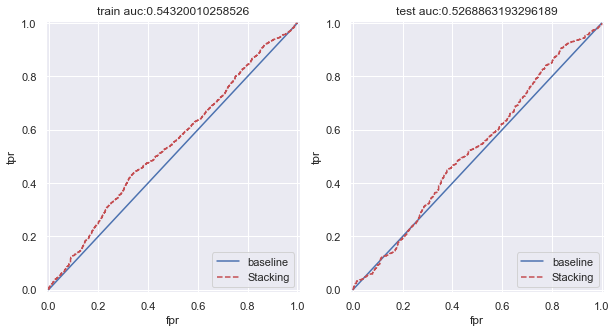

In [30]:
for name, model in model_list:
    metrics = auc_score_plot(name, model, X_train, y_train, X_test, y_test)
    auc_compare.loc[name] = metrics

- AdaBoost, GradientBoost, Stacking: generalize well. GradientBoost > AdaBoost > Stacking.
- Bagging, RandomForest, XGBoost: Overfitting.

# Iteration 2 - Hyperparameter Tuning

In [31]:
# original training set
print("the number of ACTION = 1:", len(y_train[y_train == 1]))
print("the number of ACTION = 0:", len(y_train[y_train == 0]))

the number of ACTION = 1: 21610
the number of ACTION = 0: 1328


In [32]:
# upsampling
smote = SMOTE(sampling_strategy=1, random_state=seed, k_neighbors=5, n_jobs=-1)
X_train_up, y_train_up = smote.fit_resample(X_train, y_train)
print("After upsampling, the number of ACTION = 1:", len(y_train_up[y_train_up == 1]))
print("After upsampling, the number of ACTION = 0:", len(y_train_up[y_train_up == 0]))
print("After upsampling, shape of X_train_up:", X_train_up.shape)

After upsampling, the number of ACTION = 1: 21610
After upsampling, the number of ACTION = 0: 21610
After upsampling, shape of X_train_up: (43220, 9)


In [33]:
# downsampling
downsampler = RandomUnderSampler(sampling_strategy=1, random_state=seed)
X_train_down, y_train_down = downsampler.fit_resample(X_train, y_train)
print("After downsampling, the number of ACTION = 1:", len(y_train_down[y_train_down == 1]))
print("After downsampling, the number of ACTION = 0:", len(y_train_down[y_train_down == 0]))
print("After downsampling, shape of X_train_down:", X_train_down.shape)

After downsampling, the number of ACTION = 1: 1328
After downsampling, the number of ACTION = 0: 1328
After downsampling, shape of X_train_down: (2656, 9)


## AdaBoost Tuning

In [34]:
param = {
    "base_estimator": [
        DecisionTreeClassifier(random_state = seed, max_depth = 1),
        DecisionTreeClassifier(random_state = seed, max_depth = 2),
        DecisionTreeClassifier(random_state = seed, max_depth = 3),
        DecisionTreeClassifier(random_state = seed, max_depth = 4),
        DecisionTreeClassifier(random_state = seed, max_depth = 5),        
    ],
    "n_estimators":randint(50,200),
    "learning_rate":[0.01, 0.05] + list(np.linspace(0,1,11)),
}
# Tuning with original training set
adc_tuned = AdaBoostClassifier(random_state = seed)
clf = RandomizedSearchCV(estimator = adc_tuned, param_distributions = param, n_iter=80, 
                         scoring=scorer, n_jobs=-1, cv=kfold, random_state=seed).fit(X_train, y_train)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
adc_tuned = clf.best_estimator_

C:\Users\arc_e\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.69106114 0.70237097 0.74006049 0.7646724  0.75711679 0.70772418
 0.73420306        nan 0.73426376 0.73323726 0.7487219  0.75333426
 0.74217803 0.76179808 0.75363095 0.74746967 0.73540327 0.71442861
 0.74800329 0.68377232 0.7396987  0.74997424 0.6989206  0.74377503
 0.64287034 0.75224384 0.72047632 0.70843226 0.72953843 0.70033419
 0.74317783 0.74396025 0.67140572 0.74162833 0.73273769 0.7597165
 0.75464972 0.73698755 0.65348511 0.76086828 0.74889663 0.75790332
        nan 0.73016338 0.68058771 0.74080256 0.74392334 0.71519326
 0.7533705  0.7454638  0.73095349 0.69375744 0.73187871 0.73663565
 0.75941402 0.74651848 0.76084106 0.76540067 0.70904257 0.74475443
 0.76914055 0.7310661  0.74906398 0.76655578 0.74043236 0.7291228
 0.62044354 0.72119411        nan 0.74872513 0.74171178 0.76051593
 0.76152164 0.73556499        nan 0.73515211 0.71863655

best score: 0.7691405461564119
best hyperparameters: {'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=13), 'learning_rate': 0.6000000000000001, 'n_estimators': 89}


CV AUC score is higher than before tuning.

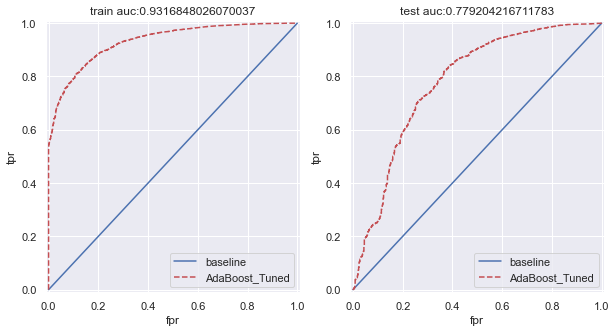

In [35]:
metrics = auc_score_plot("AdaBoost_Tuned", adc_tuned, X_train, y_train, X_test, y_test)
auc_compare.loc["AdaBoost_Tuned"] = metrics

After Tuning, AdaBoost becomes overfitting.

In [36]:
# Tuning with upsampling
adc_tuned_up = AdaBoostClassifier(random_state = seed)
clf = RandomizedSearchCV(estimator = adc_tuned_up, param_distributions = param, n_iter=50, 
                         scoring=scorer, n_jobs=-1, cv=kfold, random_state=seed).fit(X_train_up, y_train_up)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
adc_tuned_up = clf.best_estimator_

C:\Users\arc_e\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.7987449  0.82031766 0.98214936 0.97514264 0.95581246 0.82306479
 0.98149482        nan 0.9794976  0.98060335 0.97155035 0.98431531
 0.98167101 0.96460174 0.96511963 0.9738863  0.90164236 0.85989262
 0.97007124 0.78816965 0.98492632 0.95839366 0.81731952 0.98192096
 0.70470681 0.97711085 0.8906767  0.8717297  0.88903837 0.89419972
 0.98330514 0.96039372 0.76787105 0.94064635 0.90828644 0.96310355
 0.95432871 0.93645549 0.73878875 0.96475666 0.97653173 0.95835723
        nan 0.89127895 0.78209067 0.98445551 0.98063194 0.85473777
 0.97990817 0.98249948]
  warnings.warn(


best score: 0.9849263188820538
best hyperparameters: {'base_estimator': DecisionTreeClassifier(max_depth=5, random_state=13), 'learning_rate': 0.1, 'n_estimators': 180}


CV AUC score is higher than before tuning.

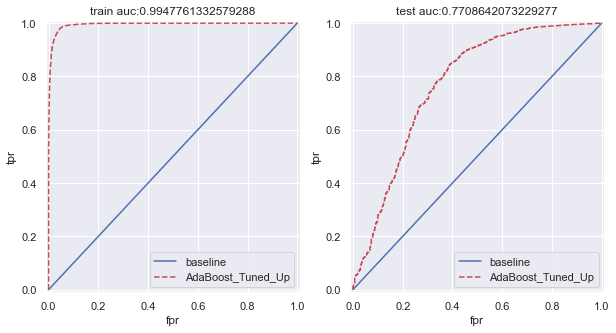

In [37]:
metrics = auc_score_plot("AdaBoost_Tuned_Up", adc_tuned_up, X_train_up, y_train_up, X_test, y_test)
auc_compare.loc["AdaBoost_Tuned_Up"] = metrics

The model becomes overfitting.

In [38]:
# Tuning with downsampling
adc_tuned_down = AdaBoostClassifier(random_state = seed)
clf = RandomizedSearchCV(estimator = adc_tuned_down, param_distributions = param, n_iter=50, 
                         scoring=scorer, n_jobs=-1, cv=kfold, random_state=seed).fit(X_train_down, y_train_down)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
adc_tuned_down = clf.best_estimator_

C:\Users\arc_e\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67412121 0.67755495 0.75639038 0.71968252 0.72609443 0.68521184
 0.72659255        nan 0.7279433  0.71093335 0.72503711 0.73897813
 0.73183934 0.73544115 0.73381059 0.72868565 0.70788984 0.68744616
 0.71550581 0.66010994 0.74827429 0.73193712 0.67875757 0.72584385
 0.63809793 0.72975328 0.70103482 0.69473386 0.69746776 0.69651939
 0.73518025 0.72214215 0.65055458 0.71559798 0.70204997 0.73789251
 0.72485753 0.72556121 0.63224413 0.72376796 0.74103009 0.73443796
        nan 0.69842105 0.66096608 0.7622921  0.71270537 0.69002114
 0.70385228 0.76049062]
  warnings.warn(


best score: 0.7622920971033057
best hyperparameters: {'base_estimator': DecisionTreeClassifier(max_depth=5, random_state=13), 'learning_rate': 0.4, 'n_estimators': 158}


CV AUC score is higher than before tuning.

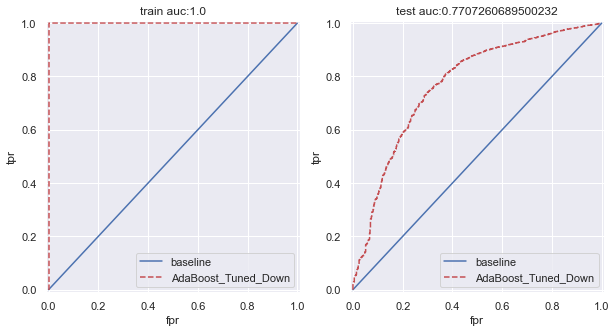

In [39]:
metrics = auc_score_plot("AdaBoost_Tuned_Down", adc_tuned_down, X_train_down, y_train_down, X_test, y_test)
auc_compare.loc["AdaBoost_Tuned_Down"] = metrics

The model becomes overfitting.

## GradientBoost Tuning

In [40]:
param = {
    "subsample": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "max_depth": [3,4,5],
    "min_impurity_decrease":[0, 0.1, 0.01, 0.001, 0.0001],
    "max_features":[None, "sqrt", "log2", 0.5, 0.6, 0.7, 0.8, 0.9],
    "n_estimators":randint(100,250),
    "learning_rate":[0.01, 0.05] + list(np.linspace(0,1,11)),
}
# Tuning with original training set
gbc_tuned = GradientBoostingClassifier(random_state = seed)
clf = RandomizedSearchCV(estimator = gbc_tuned, param_distributions = param, n_iter=40, 
                         scoring=scorer, n_jobs=-1, cv=kfold, random_state=seed).fit(X_train, y_train)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
gbc_tuned = clf.best_estimator_

C:\Users\arc_e\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.737805   0.79306889 0.81744564 0.71236558 0.75123731
 0.74118345 0.79297555 0.78344435 0.80737397 0.77954543 0.72085031
 0.7924024  0.77304734 0.73957463 0.80414709 0.73233253 0.7869726
 0.7795451  0.7350811  0.74219042 0.71542093 0.771506   0.75650432
 0.78722124        nan 0.79151684 0.77296519 0.77519941 0.69547055
 0.77427102 0.73818542 0.73806467 0.7660973  0.77981167 0.73379162
 0.78825761 0.77228499 0.77239121 0.74743933]
  warnings.warn(


best score: 0.8174456365434029
best hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': None, 'min_impurity_decrease': 0.001, 'n_estimators': 249, 'subsample': 0.7}


CV AUC score is higher than before tuning.

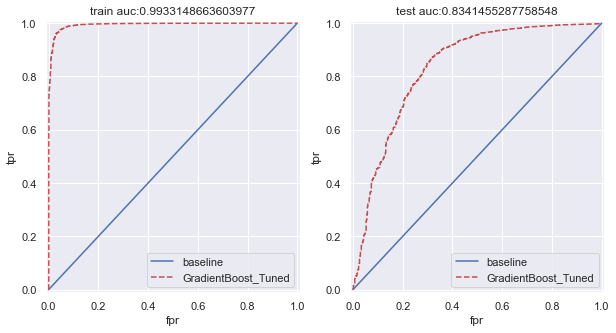

In [41]:
metrics = auc_score_plot("GradientBoost_Tuned", gbc_tuned, X_train, y_train, X_test, y_test)
auc_compare.loc["GradientBoost_Tuned"] = metrics

After tuning, GradientBoost becomes overfitting.

In [42]:
# Tuning with upsampling
gbc_tuned_up = GradientBoostingClassifier(random_state = seed)
clf = RandomizedSearchCV(estimator = gbc_tuned_up, param_distributions = param, n_iter=40, 
                         scoring=scorer, n_jobs=-1, cv=kfold, random_state=seed).fit(X_train_up, y_train_up)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
gbc_tuned_up = clf.best_estimator_

C:\Users\arc_e\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.98223341 0.98656138 0.99009084 0.98043238 0.97818524
 0.98652742 0.9759754  0.97998919 0.98394771 0.98938476 0.85452336
 0.97624831 0.98059087 0.8803001  0.98537134 0.86903163 0.9872171
 0.96048465 0.98428851 0.89990575 0.97928642 0.92521225 0.92280378
 0.95195073        nan 0.98221635 0.95220248 0.94681655 0.9756431
 0.95999267 0.87713644 0.9828746  0.98751346 0.97509176 0.97978064
 0.95867774 0.97994891 0.97732714 0.98341838]
  warnings.warn(


best score: 0.9900908387957742
best hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': None, 'min_impurity_decrease': 0.001, 'n_estimators': 249, 'subsample': 0.7}


CV AUC score is higher than before tuning.

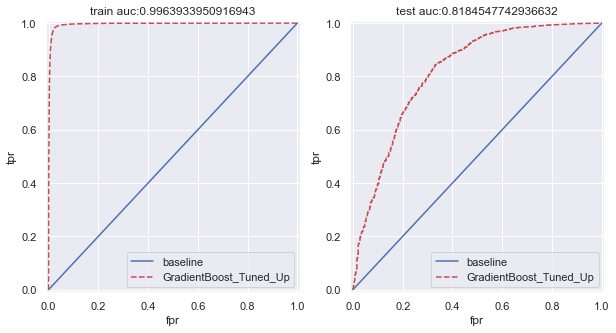

In [43]:
metrics = auc_score_plot("GradientBoost_Tuned_Up", gbc_tuned_up, X_train_up, y_train_up, X_test, y_test)
auc_compare.loc["GradientBoost_Tuned_Up"] = metrics

The model becomes overfitting.

In [44]:
# Tuning with downsampling
gbc_tuned_down = GradientBoostingClassifier(random_state = seed)
clf = RandomizedSearchCV(estimator = gbc_tuned_down, param_distributions = param, n_iter=40, 
                         scoring=scorer, n_jobs=-1, cv=kfold, random_state=seed).fit(X_train_down, y_train_down)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
gbc_tuned_down = clf.best_estimator_

C:\Users\arc_e\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.72464837 0.77153887 0.78825389 0.69759843 0.72149072
 0.70124687 0.76608912 0.74911112 0.77741949 0.78956783 0.70974577
 0.76906768 0.75008613 0.71530699 0.77318736 0.71094112 0.77195915
 0.75262322 0.71077087 0.72291755 0.66569448 0.74235961 0.73171578
 0.76159126        nan 0.76487874 0.75052682 0.74605858 0.64144542
 0.74853066 0.72156984 0.70802879 0.75975465 0.74944536 0.71248131
 0.76264261 0.75901416 0.74700454 0.7440974 ]
  warnings.warn(


best score: 0.7895678265034127
best hyperparameters: {'learning_rate': 0.6000000000000001, 'max_depth': 5, 'max_features': 0.7, 'min_impurity_decrease': 0.0001, 'n_estimators': 247, 'subsample': 0.9}


CV AUC score is higher than before tuning.

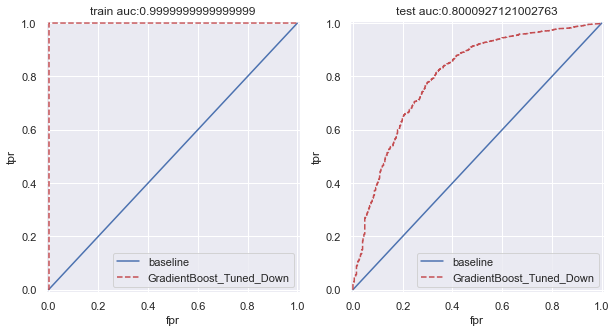

In [45]:
metrics = auc_score_plot("GradientBoost_Tuned_Down", gbc_tuned_down, X_train_down, y_train_down, X_test, y_test)
auc_compare.loc["GradientBoost_Tuned_Down"] = metrics

The model becomes overfitting.

## Bagging Tuning

In [46]:
param = {
    "base_estimator": [
        DecisionTreeClassifier(random_state = seed, max_depth = 1),
        DecisionTreeClassifier(random_state = seed, max_depth = 2),
        DecisionTreeClassifier(random_state = seed, max_depth = 3),
        DecisionTreeClassifier(random_state = seed, max_depth = 4),
        DecisionTreeClassifier(random_state = seed, max_depth = 5),        
    ],    
    "max_samples": np.linspace(0,1,11),
    "max_features":np.linspace(0,1,11),
    "n_estimators":randint(10,100),

}
# Tuning with original training set
bgc_tuned = BaggingClassifier(n_jobs = -1, random_state = seed)
clf = RandomizedSearchCV(estimator = bgc_tuned, param_distributions = param, n_iter=50, 
                         scoring=scorer, n_jobs=-1, cv=kfold, random_state=seed).fit(X_train, y_train)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
bgc_tuned = clf.best_estimator_

C:\Users\arc_e\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.67018575 0.68275858 0.63389169 0.60657407 0.69695793
 0.6583795  0.67756254 0.65249994 0.6123652  0.63109803 0.65063818
        nan 0.60393247 0.68335122 0.61289678 0.62199915 0.68012164
 0.60318358 0.70217565 0.68576889 0.6553096         nan 0.70735105
 0.6132149  0.58678238        nan 0.63812666 0.59973583 0.62374402
        nan 0.61173186 0.61543298 0.60389257 0.65944541 0.68601945
 0.60964326 0.72465969        nan 0.68209564        nan        nan
 0.60342397        nan 0.6489852  0.6333564  0.62064424 0.65328885
 0.60378213 0.65405762]
  warnings.warn(


best score: 0.7246596883230751
best hyperparameters: {'base_estimator': DecisionTreeClassifier(max_depth=5, random_state=13), 'max_features': 0.6000000000000001, 'max_samples': 0.8, 'n_estimators': 91}


CV AUC score is lower than before tuning.

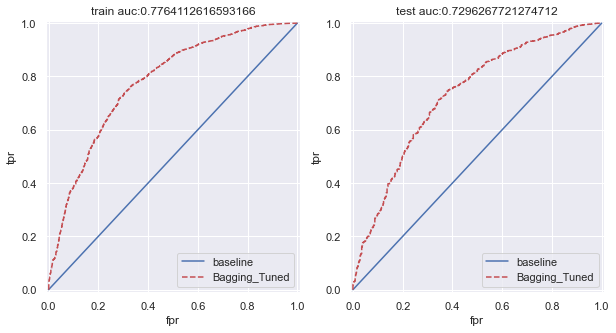

In [47]:
metrics = auc_score_plot("Bagging_Tuned", bgc_tuned, X_train, y_train, X_test, y_test)
auc_compare.loc["Bagging_Tuned"] = metrics

After Tunig, Bagging model generalizes well with train and test set.

In [48]:
# Tuning with upsampling
bgc_tuned_up = BaggingClassifier(n_jobs = -1, random_state = seed)
clf = RandomizedSearchCV(estimator = bgc_tuned_up, param_distributions = param, n_iter=50, 
                         scoring=scorer, n_jobs=-1, cv=kfold, random_state=seed).fit(X_train_up, y_train_up)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
bgc_tuned_up = clf.best_estimator_

C:\Users\arc_e\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.79252571 0.7956638  0.73123473 0.68451611 0.83408592
 0.7593046  0.80722796 0.77862053 0.69062997 0.71156136 0.73331687
        nan 0.59729292 0.81549973 0.66880283 0.69559493 0.81590478
 0.59729292 0.84659384 0.83749504 0.76181954        nan 0.847734
 0.6903837  0.67821519        nan 0.7362291  0.6644707  0.70110471
        nan 0.69870553 0.69375358 0.67061254 0.75106989 0.79976031
 0.68382726 0.87748671        nan 0.80133409        nan        nan
 0.67514606        nan 0.74495676 0.71763863 0.69412934 0.75314851
 0.66842616 0.76254675]
  warnings.warn(


best score: 0.8774867069485758
best hyperparameters: {'base_estimator': DecisionTreeClassifier(max_depth=5, random_state=13), 'max_features': 0.6000000000000001, 'max_samples': 0.8, 'n_estimators': 91}


CV AUC score is higher than before tuning.

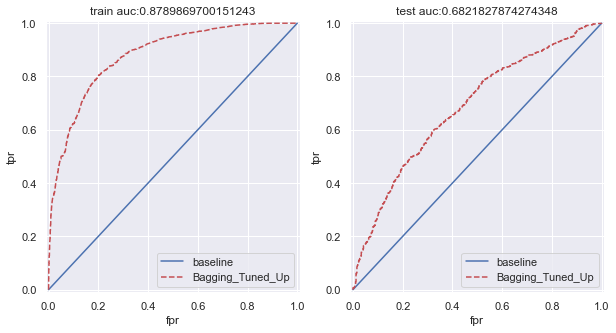

In [49]:
metrics = auc_score_plot("Bagging_Tuned_Up", bgc_tuned_up, X_train_up, y_train_up, X_test, y_test)
auc_compare.loc["Bagging_Tuned_Up"] = metrics

The model becomes overfitting. Test AUC decreases to less than 0.7.

In [50]:
# Tuning with downsampling
bgc_tuned_down = BaggingClassifier(n_jobs = -1, random_state = seed)
clf = RandomizedSearchCV(estimator = bgc_tuned_down, param_distributions = param, n_iter=50, 
                         scoring=scorer, n_jobs=-1, cv=kfold, random_state=seed).fit(X_train_down, y_train_down)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
bgc_tuned_down = clf.best_estimator_

best score: 0.7227883761041134
best hyperparameters: {'base_estimator': DecisionTreeClassifier(max_depth=5, random_state=13), 'max_features': 0.6000000000000001, 'max_samples': 0.8, 'n_estimators': 91}


C:\Users\arc_e\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.67465002 0.69712015 0.6586903  0.59750661 0.69431441
 0.64739064 0.68792814 0.65921162 0.61437934 0.64157536 0.66509855
        nan 0.60334096 0.66628568 0.62560414 0.64213714 0.67808155
 0.59840898 0.71196217 0.68582433 0.63467242        nan 0.69638698
 0.60442191 0.59954593        nan 0.66994851 0.599334   0.6423109
        nan 0.6071535  0.61156682 0.60241375 0.64338179 0.66431946
 0.60901999 0.72278838        nan 0.69259909        nan        nan
 0.61944754        nan 0.67216842 0.64676411 0.64169538 0.66735276
 0.60465526 0.67057189]
  warnings.warn(


CV AUC score is lower than before tuning.

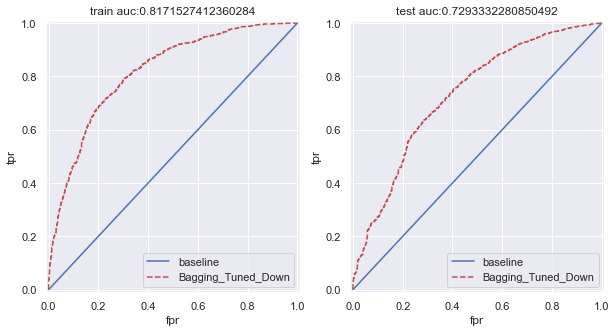

In [51]:
metrics = auc_score_plot("Bagging_Tuned_Down", bgc_tuned_down, X_train_down, y_train_down, X_test, y_test)
auc_compare.loc["Bagging_Tuned_Down"] = metrics

The model is a bit overfitting.

## RandomForest Tunig

In [52]:
param = {
    "min_impurity_decrease": [0,0.1,0.01,0.001,0.0001],
    "max_samples":[0.5,0.6,0.7,0.8,0.9,1],
    "max_features": [None, "sqrt", "log2", 0.5, 0.6,0.7,0.8,0.9],
    "max_depth":[1,2,3,4,5,6],
    "n_estimators":randint(100,250),
}
# Tuning with original traing set
rf_tuned = RandomForestClassifier(n_jobs = -1, random_state = seed)
clf = RandomizedSearchCV(estimator = rf_tuned, param_distributions = param, n_iter=50, 
                         scoring=scorer, n_jobs=-1, cv=kfold, random_state=seed).fit(X_train, y_train)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
rf_tuned = clf.best_estimator_

best score: 0.742396425589394
best hyperparameters: {'max_depth': 6, 'max_features': 0.7, 'max_samples': 0.7, 'min_impurity_decrease': 0, 'n_estimators': 127}


CV AUC score is lower than before tunig.

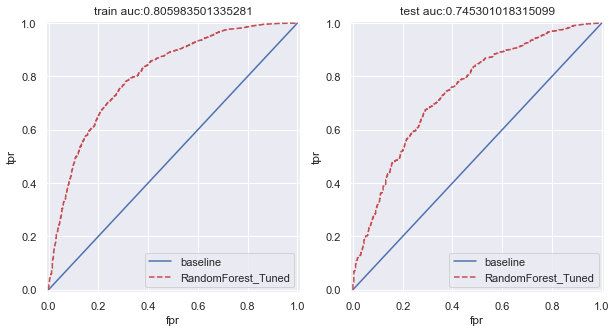

In [53]:
metrics = auc_score_plot("RandomForest_Tuned", rf_tuned, X_train, y_train, X_test, y_test)
auc_compare.loc["RandomForest_Tuned"] = metrics

After Tunig, RandomForest model generalizes well with train and test set.

In [54]:
# Tuning with upsampling
rf_tuned_up = RandomForestClassifier(n_jobs = -1, random_state = seed)
clf = RandomizedSearchCV(estimator = rf_tuned_up, param_distributions = param, n_iter=50, 
                         scoring=scorer, n_jobs=-1, cv=kfold, random_state=seed).fit(X_train_up, y_train_up)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
rf_tuned_up = clf.best_estimator_

best score: 0.8979257411420878
best hyperparameters: {'max_depth': 6, 'max_features': 0.7, 'max_samples': 0.7, 'min_impurity_decrease': 0, 'n_estimators': 127}


CV AUC score is higher than before tunig.

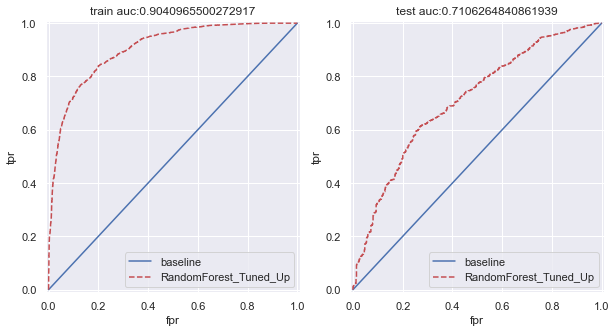

In [55]:
metrics = auc_score_plot("RandomForest_Tuned_Up", rf_tuned_up, X_train_up, y_train_up, X_test, y_test)
auc_compare.loc["RandomForest_Tuned_Up"] = metrics

Model becomes overfitting.

In [56]:
# Tuning with downsampling
rf_tuned_down = RandomForestClassifier(n_jobs = -1, random_state = seed)
clf = RandomizedSearchCV(estimator = rf_tuned_down, param_distributions = param, n_iter=50, 
                         scoring=scorer, n_jobs=-1, cv=kfold, random_state=seed).fit(X_train_down, y_train_down)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
rf_tuned_down = clf.best_estimator_

best score: 0.7328062317803303
best hyperparameters: {'max_depth': 6, 'max_features': 0.7, 'max_samples': 0.7, 'min_impurity_decrease': 0, 'n_estimators': 127}


CV AUC score is lower than before tunig.

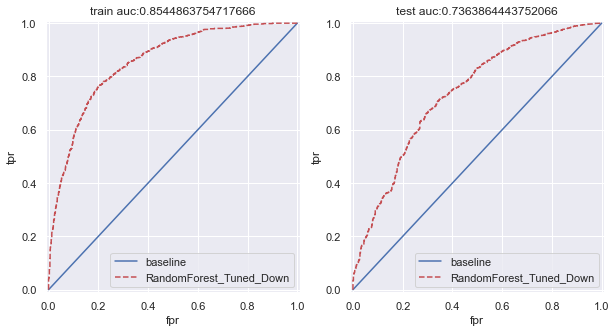

In [57]:
metrics = auc_score_plot("RandomForest_Tuned_Down", rf_tuned_down, X_train_down, y_train_down, X_test, y_test)
auc_compare.loc["RandomForest_Tuned_Down"] = metrics

Model becomes overfitting.

## XGBoost Tuning

In [58]:
param = {
    "learning_rate": [0.2, 0.3, 0.4, 0.5],
    "subsample":[0.6,0.7,0.8,0.9],
    "colsample_bylevel":[0.6,0.7,0.8,0.9],
    "max_depth":randint(2,7),
    "n_estimators":randint(40,110),
}
# Tuning with original traing set
xgb_tuned = XGBClassifier(objective='binary:logistic', random_state = seed, n_jobs = -1)
clf = RandomizedSearchCV(estimator = xgb_tuned, param_distributions = param, n_iter=50, 
                         scoring=scorer, n_jobs=-1, cv=kfold, random_state=seed).fit(X_train, y_train)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
xgb_tuned = clf.best_estimator_

C:\Users\arc_e\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\arc_e\anaconda3\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[14:05:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best score: 0.8135513677018194
best hyperparameters: {'colsample_bylevel': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 87, 'subsample': 0.9}


CV AUC score is a bit lower than before tuning.

[14:05:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


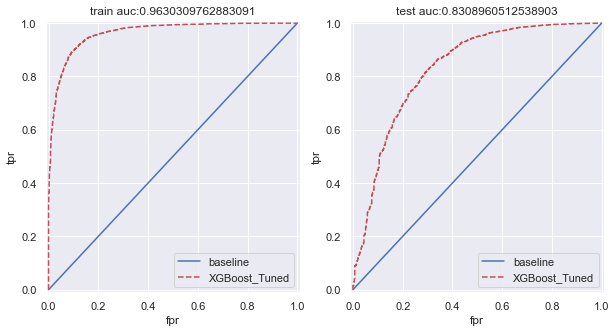

In [59]:
metrics = auc_score_plot("XGBoost_Tuned", xgb_tuned, X_train, y_train, X_test, y_test)
auc_compare.loc["XGBoost_Tuned"] = metrics

Still overfitting. Little improvement.

## Stacking Tuning

In [60]:
param = {
    "final_estimator":[adc, gbc, bgc_tuned, rf_tuned]
}
# original training set
stack_tuned = StackingClassifier(estimators = [
    ("adc",adc),
    ("gbc",gbc),
    ("bgc_tuned", bgc_tuned),
    ("rf_tuned", rf_tuned),
],
cv=3, n_jobs=-1, passthrough=True)

clf = GridSearchCV(estimator = stack_tuned, param_grid = param, scoring=scorer, n_jobs=-1, cv=kfold).fit(X_train, y_train)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
stack_tuned = clf.best_estimator_

best score: 0.764599777822841
best hyperparameters: {'final_estimator': GradientBoostingClassifier(random_state=13)}


CV AUC score is much higher than before tuning.

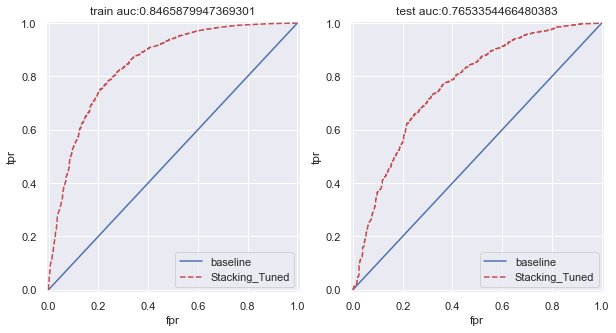

In [61]:
metrics = auc_score_plot("Stacking_Tuned", stack_tuned, X_train, y_train, X_test, y_test)
auc_compare.loc["Stacking_Tuned"] = metrics

The model is a bit overfitting.

In [62]:
# upsampling
stack_tuned_up = StackingClassifier(estimators = [
    ("adc",adc),
    ("gbc",gbc),
    ("bgc_tuned", bgc_tuned),
    ("rf_tuned", rf_tuned),
],
cv=3, n_jobs=-1, passthrough=True)

clf = GridSearchCV(estimator = stack_tuned_up, param_grid = param, scoring=scorer, n_jobs=-1,
                   cv=kfold).fit(X_train_up, y_train_up)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
stack_tuned_up = clf.best_estimator_

best score: 0.9524674721478158
best hyperparameters: {'final_estimator': GradientBoostingClassifier(random_state=13)}


CV AUC score is much higher than before tuning.

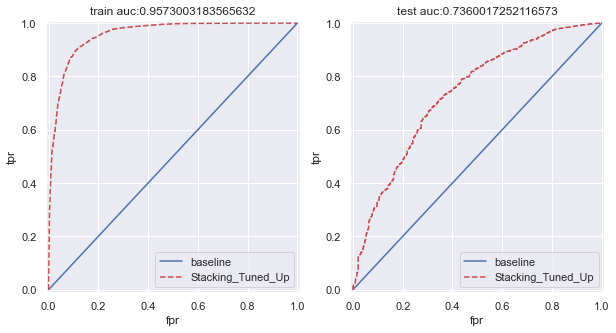

In [63]:
metrics = auc_score_plot("Stacking_Tuned_Up", stack_tuned_up, X_train_up, y_train_up, X_test, y_test)
auc_compare.loc["Stacking_Tuned_Up"] = metrics

The model is overfitting.

In [64]:
# downsampling
stack_tuned_down = StackingClassifier(estimators = [
    ("adc",adc),
    ("gbc",gbc),
    ("bgc_tuned", bgc_tuned),
    ("rf_tuned", rf_tuned),
],
cv=3, n_jobs=-1, passthrough=True)

clf = GridSearchCV(estimator = stack_tuned_down, param_grid = param, scoring=scorer, n_jobs=-1,
                   cv=kfold).fit(X_train_down, y_train_down)
print("best score:", clf.best_score_)
print("best hyperparameters:", clf.best_params_)
stack_tuned_down = clf.best_estimator_

best score: 0.7384154900657801
best hyperparameters: {'final_estimator': RandomForestClassifier(max_depth=6, max_features=0.7, max_samples=0.7,
                       min_impurity_decrease=0, n_estimators=127, n_jobs=-1,
                       random_state=13)}


CV AUC score is much higher than before tuning.

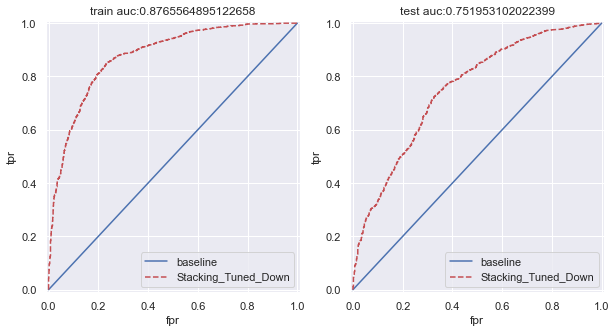

In [65]:
metrics = auc_score_plot("Stacking_Tuned_Down", stack_tuned_down, X_train_down, y_train_down, X_test, y_test)
auc_compare.loc["Stacking_Tuned_Down"] = metrics

The model is a bit overfitting.

## Conclusion of Iteration 2

In [66]:
auc_compare.sort_values(by = "Test AUC", ascending = False)

,Train AUC,Test AUC
Model,,
RandomForest,1.000000,0.838808
XGB,0.982001,0.838321
GradientBoost_Tuned,0.993315,0.834146
XGBoost_Tuned,0.963031,0.830896
GradientBoost_Tuned_Up,0.996393,0.818455
GradientBoost_Tuned_Down,1.000000,0.800093
Bagging,0.999639,0.788446
AdaBoost_Tuned,0.931685,0.779204
AdaBoost_Tuned_Up,0.994776,0.770864


- Stacking_Tuned, Stacking_Tuned_Down, RandomForest_Tuned, GradientBoost, RandomForest_Tuned_Down, Bagging_Tuned, Bagging_Tuned_Down, AdaBoost, Stacking: generalize well with train and test set.
- The remainings are somewhat overfitting.
- Among the generalized models, Stacking_Tuned has the highest test auc.
- Among the overfitting models, RandomForest has the highest test auc.

# Conclusion

In [71]:
optimal_model = stack_tuned
y_final_test_pred = pd.DataFrame(data = {"Id": final_test_id, "ACTION": optimal_model.predict(X_final_test)})
y_final_test_pred.head()

,Id,ACTION
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [72]:
y_final_test_pred.shape

(58921, 2)

In [73]:
len(y_final_test_pred[y_final_test_pred.ACTION == 0])

564

In [74]:
y_final_test_pred.to_csv('Amazon_Employee_Acess_Submission_rf.csv', index=False)